In [2]:
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import collections

import nengo_loihi

(50000, 32, 32, 3)
(50000, 3, 32, 32)


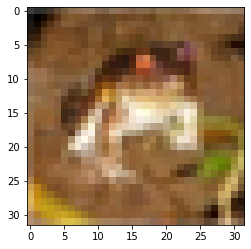

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#train_x[0] # 0 to 255 range.
print(train_x.shape)
plt.imshow(train_x[0])
train_x, test_x = np.moveaxis(train_x, -1, 1), np.moveaxis(test_x, -1, 1)
print(train_x.shape)

In [3]:
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    data_format="channels_first",
)
train_idg.fit(train_x)

In [4]:
class NengoImageIterator(tf.keras.preprocessing.image.Iterator):
    def __init__(
        self,
        image_data_generator,
        x_keys,
        x,
        y_keys,
        y,
        batch_size=32,
        shuffle=False,
        sample_weight=None,
        seed=None,
        subset=None,
        dtype="float32",
    ):
        assert subset is None, "Not Implemented"
        assert isinstance(x_keys, (tuple, list))
        assert isinstance(y_keys, (tuple, list))
        assert isinstance(x, (tuple, list))
        assert isinstance(y, (tuple, list))

        self.dtype = dtype
        self.x_keys = x_keys
        self.y_keys = y_keys

        x0 = x[0]
        assert all(len(xx) == len(x0) for xx in x), (
            "All of the arrays in `x` should have the same length. "
            "[len(xx) for xx in x] = %s" % ([len(xx) for xx in x],)
        )
        assert all(len(yy) == len(x0) for yy in y), (
            "All of the arrays in `y` should have the same length as `x`. "
            "len(x[0]) = %d, [len(yy) for yy in y] = %s"
            % (len(x0), [len(yy) for yy in y])
        )
        assert len(x_keys) == len(x)
        assert len(y_keys) == len(y)

        if sample_weight is not None and len(x0) != len(sample_weight):
            raise ValueError(
                "`x[0]` (images tensor) and `sample_weight` "
                "should have the same length. "
                "Found: x.shape = %s, sample_weight.shape = %s"
                % (np.asarray(x0).shape, np.asarray(sample_weight).shape)
            )

        self.x = [
            np.asarray(xx, dtype=self.dtype if i == 0 else None)
            for i, xx in enumerate(x)
        ]
        if self.x[0].ndim != 4:
            raise ValueError(
                "Input data in `NumpyArrayIterator` "
                "should have rank 4. You passed an array "
                "with shape",
                self.x[0].shape,
            )

        self.y = [np.asarray(yy) for yy in y]
        self.sample_weight = (
            None if sample_weight is None else np.asarray(sample_weight)
        )
        self.image_data_generator = image_data_generator
        super().__init__(self.x[0].shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        print("RG, Index Array: ", index_array)
        images = self.x[0]
        assert images.dtype == self.dtype

        n = len(index_array)
        batch_x = np.zeros((n,) + images[0].shape, dtype=self.dtype)
        for i, j in enumerate(index_array):
            x = images[j]
            params = self.image_data_generator.get_random_transform(x.shape)
            x = self.image_data_generator.apply_transform(x, params)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x

        batch_x_miscs = [xx[index_array] for xx in self.x[1:]]
        batch_y_miscs = [yy[index_array] for yy in self.y]

        x_pairs = [
            (k, self.x_postprocess(k, v))
            for k, v in zip(self.x_keys, [batch_x] + batch_x_miscs)
        ]
        y_pairs = [
            (k, self.y_postprocess(k, v)) for k, v in zip(self.y_keys, batch_y_miscs)
        ]

        output = (
            collections.OrderedDict(x_pairs),
            collections.OrderedDict(y_pairs),
        )

        if self.sample_weight is not None:
            output += (self.sample_weight[index_array],)
        return output

    def x_postprocess(self, key, x):
        return x if key == "n_steps" else x.reshape((x.shape[0], 1, -1))

    def y_postprocess(self, key, y):
        return y.reshape((y.shape[0], 1, -1))

# ###################################################################

In [5]:
def percentile_l2_loss_range(
    y_true, y, sample_weight=None, min_rate=0.0, max_rate=np.inf, percentile=99.0
):
    # y axes are (batch examples, time (==1), neurons)
    assert len(y.shape) == 3
    rates = tfp.stats.percentile(y, percentile, axis=(0, 1))
    low_error = tf.maximum(0.0, min_rate - rates)
    high_error = tf.maximum(0.0, rates - max_rate)
    loss = tf.nn.l2_loss(low_error + high_error)

    return (sample_weight * loss) if sample_weight is not None else loss


def slice_data_dict(data, slice_):
    return {key: value[slice_] for key, value in data.items()}

In [6]:
channels_last = True

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

n_classes = len(np.unique(train_y))

# TensorFlow does not include the label names, so define them manually
label_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
assert n_classes == len(label_names)

if not channels_last:
    train_x = np.transpose(train_x, (0, 3, 1, 2))
    test_x = np.transpose(test_x, (0, 3, 1, 2))

# convert the images to float32, and rescale to [-1, 1]
train_x = train_x.astype(np.float32) / 127.5 - 1
test_x = test_x.astype(np.float32) / 127.5 - 1

train_t = np.array(tf.one_hot(train_y, n_classes), dtype=np.float32)
test_t = np.array(tf.one_hot(test_y, n_classes), dtype=np.float32)

train_y = train_y.squeeze()
test_y = test_y.squeeze()

train_x_flat = train_x.reshape((train_x.shape[0], 1, -1))
train_t_flat = train_t.reshape((train_t.shape[0], 1, -1))

test_x_flat = test_x.reshape((test_x.shape[0], 1, -1))
test_t_flat = test_t.reshape((test_t.shape[0], 1, -1))

input_shape = nengo.transforms.ChannelShape(
    test_x[0].shape, channels_last=channels_last
)
assert input_shape.n_channels in (1, 3)
assert train_x[0].shape == test_x[0].shape == input_shape.shape

In [7]:
max_rate = 150
amp = 1.0 / max_rate
rate_reg = 1e-3
rate_target = max_rate * amp  # must be in amplitude scaled units

relu = nengo.SpikingRectifiedLinear(amplitude=amp)
chip_neuron = nengo_loihi.neurons.LoihiLIF(amplitude=amp)

layer_confs = [
    dict(
        name="input-layer",
        filters=4,
        kernel_size=1,
        strides=1,
        neuron=relu,
        on_chip=False,
    ),
    dict(name="conv-layer1", filters=64, kernel_size=3, strides=2, block=(8, 8, 16)),
    dict(name="conv-layer2", filters=72, kernel_size=3, strides=1, block=(7, 7, 8)),
    dict(name="conv-layer3", filters=256, kernel_size=3, strides=2, block=(6, 6, 12)),
    dict(name="conv-layer4", filters=256, kernel_size=1, strides=1, block=(6, 6, 24)),
    dict(name="conv-layer5", filters=64, kernel_size=1, strides=1, block=(6, 6, 24)),
    dict(name="dense-layer", n_neurons=100, block=(50,)),
    dict(name="output-layer", n_neurons=10, neuron=None, on_chip=False),
]

# Create a PresentInput process to show images from the training set sequentially.
# Each image is presented for `presentation_time` seconds.
# NOTE: this is not used during training, since we get `nengo_dl` to override the
# output of this node with the training data.
presentation_time = 0.2
present_images = nengo.processes.PresentInput(test_x_flat, presentation_time)

total_n_neurons = 0
total_n_weights = 0

with nengo.Network() as net:
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # add a configurable keep_history option to Probes (we'll set this
    # to False for some probes below)
    nengo_dl.configure_settings(keep_history=True)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # this sets the amount of smoothing used on the LIF neurons during training
    nengo_dl.configure_settings(lif_smoothing=0.01)

    # this allows us to set `nengo_loihi` parameters like `on_chip` and `block_shape`
    nengo_loihi.add_params(net)

    # the input node that will be used to feed in input images
    inp = nengo.Node(present_images, label="input_node")

    connections = []
    transforms = []
    layer_probes = []
    shape_in = input_shape
    x = inp
    for k, layer_conf in enumerate(layer_confs):
        layer_conf = dict(layer_conf)  # copy, so we don't modify the original
        name = layer_conf.pop("name")
        neuron_type = layer_conf.pop("neuron", chip_neuron)
        on_chip = layer_conf.pop("on_chip", True)
        block = layer_conf.pop("block", None)

        if block is not None and not channels_last:
            # move channels to first index
            block = (block[-1],) + block[:-1]

        # --- create layer transform
        if "filters" in layer_conf:
            # convolutional layer
            n_filters = layer_conf.pop("filters")
            kernel_size = layer_conf.pop("kernel_size")
            strides = layer_conf.pop("strides", 1)
            assert len(layer_conf) == 0, "Unused fields in conv layer: %s" % list(
                layer_conf
            )

            kernel_size = (
                (kernel_size, kernel_size)
                if isinstance(kernel_size, int)
                else kernel_size
            )
            strides = (strides, strides) if isinstance(strides, int) else strides

            transform = nengo.Convolution(
                n_filters=n_filters,
                input_shape=shape_in,
                kernel_size=kernel_size,
                strides=strides,
                padding="valid",
                channels_last=channels_last,
                init=nengo_dl.dists.Glorot(scale=1.0 / np.prod(kernel_size)),
            )
            shape_out = transform.output_shape

            loc = "chip" if on_chip else "host"
            n_neurons = np.prod(shape_out.shape)
            n_weights = np.prod(transform.kernel_shape)
            print(
                "%s: %s: conv %s, stride %s, output %s (%d neurons, %d weights)"
                % (
                    loc,
                    name,
                    kernel_size,
                    strides,
                    shape_out.shape,
                    n_neurons,
                    n_weights,
                )
            )
        else:
            # dense layer
            n_neurons = layer_conf.pop("n_neurons")

            shape_out = nengo.transforms.ChannelShape((n_neurons,))
            transform = nengo.Dense(
                (shape_out.size, shape_in.size),
                init=nengo_dl.dists.Glorot(),
            )

            loc = "chip" if on_chip else "host"
            n_weights = np.prod(transform.shape)
            print(
                "%s: %s: dense %d, output %s (%d neurons, %d weights)"
                % (loc, name, n_neurons, shape_out.shape, n_neurons, n_weights)
            )

        assert len(layer_conf) == 0, "Unused fields in %s: %s" % (
            [name] + list(layer_conf)
        )

        total_n_neurons += n_neurons
        total_n_weights += n_weights

        # --- create layer output (Ensemble or Node)
        assert on_chip or block is None, "`block` must be None if off-chip"

        if neuron_type is None:
            assert not on_chip, "Nodes can only be run off-chip"
            y = nengo.Node(size_in=shape_out.size, label=name)
        else:
            ens = nengo.Ensemble(shape_out.size, 1, neuron_type=neuron_type, label=name)
            net.config[ens].on_chip = on_chip
            y = ens.neurons

            if block is not None:
                net.config[ens].block_shape = nengo_loihi.BlockShape(
                    block,
                    shape_out.shape,
                )

            # add a probe so we can measure individual layer rates
            probe = nengo.Probe(y, synapse=None, label="%s_p" % name)
            net.config[probe].keep_history = False
            layer_probes.append(probe)

        conn = nengo.Connection(x, y, transform=transform)
        net.config[conn].pop_type = 32

        transforms.append(transform)
        connections.append(conn)
        x = y
        shape_in = shape_out

    output_p = nengo.Probe(x, synapse=None, label="output_p")

print("TOTAL: %d neurons, %d weights" % (total_n_neurons, total_n_weights))
assert len(layer_confs) == len(transforms) == len(connections)

host: input-layer: conv (1, 1), stride (1, 1), output (32, 32, 4) (4096 neurons, 12 weights)
chip: conv-layer1: conv (3, 3), stride (2, 2), output (15, 15, 64) (14400 neurons, 2304 weights)
chip: conv-layer2: conv (3, 3), stride (1, 1), output (13, 13, 72) (12168 neurons, 41472 weights)
chip: conv-layer3: conv (3, 3), stride (2, 2), output (6, 6, 256) (9216 neurons, 165888 weights)
chip: conv-layer4: conv (1, 1), stride (1, 1), output (6, 6, 256) (9216 neurons, 65536 weights)
chip: conv-layer5: conv (1, 1), stride (1, 1), output (6, 6, 64) (2304 neurons, 16384 weights)
chip: dense-layer: dense 100, output (100,) (100 neurons, 230400 weights)
host: output-layer: dense 10, output (10,) (10 neurons, 1000 weights)
TOTAL: 51510 neurons, 522996 weights


In [8]:
# define input and target dictionaries to pass to NengoDL
train_inputs = {inp: train_x_flat}
train_targets = {output_p: train_t_flat}

test_inputs = {inp: test_x_flat}
test_targets = {output_p: test_t_flat}
for probe in layer_probes:
    train_targets[probe] = np.zeros((train_t_flat.shape[0], 1, 0), dtype=np.float32)
    test_targets[probe] = np.zeros((test_t_flat.shape[0], 1, 0), dtype=np.float32)

In [9]:
# --- evaluate layers
# use rate neurons always by setting learning_phase_scope
with tf.keras.backend.learning_phase_scope(1), nengo_dl.Simulator(
    net, minibatch_size=100, progress_bar=False
) as sim:
    for conf, conn in zip(layer_confs, connections):
        weights = sim.model.sig[conn]["weights"].initial_value
        print("%s: initial weights: %0.3f" % (conf["name"], np.abs(weights).mean()))

    sim.run_steps(1, data={inp: train_x_flat[:100]})

for conf, layer_probe in zip(layer_confs, layer_probes):
    out = sim.data[layer_probe][-1]
    print("%s: initial rates: %0.3f" % (conf["name"], np.mean(out)))

input-layer: initial weights: 0.416
conv-layer1: initial weights: 0.049
conv-layer2: initial weights: 0.035
conv-layer3: initial weights: 0.023
conv-layer4: initial weights: 0.054
conv-layer5: initial weights: 0.068
dense-layer: initial weights: 0.025
output-layer: initial weights: 0.118
input-layer: initial rates: 0.215
conv-layer1: initial rates: 0.000
conv-layer2: initial rates: 0.000
conv-layer3: initial rates: 0.000
conv-layer4: initial rates: 0.000
conv-layer5: initial rates: 0.000
dense-layer: initial rates: 0.000


In [10]:
do_training = False

checkpoint_base = "./cifar10_convnet_params"

batch_size = 256

train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    data_format="channels_last" if channels_last else "channels_first",
)
train_idg.fit(train_x)

# use rate neurons always by setting learning_phase_scope
with tf.keras.backend.learning_phase_scope(1), nengo_dl.Simulator(
    net, minibatch_size=batch_size
) as sim:

    percentile = 99.9

    def rate_metric(_, outputs):
        # take percentile over all examples, for each neuron
        top_rates = tfp.stats.percentile(outputs, percentile, axis=(0, 1))
        return tf.reduce_mean(top_rates) / amp

    losses = collections.OrderedDict()
    metrics = collections.OrderedDict()
    loss_weights = collections.OrderedDict()

    losses[output_p] = tf.losses.CategoricalCrossentropy(from_logits=True)
    metrics[output_p] = "accuracy"
    loss_weights[output_p] = 1.0

    for probe, layer_conf in zip(layer_probes, layer_confs):
        metrics[probe] = rate_metric

        if layer_conf.get("on_chip", True):
            losses[probe] = partial(
                percentile_l2_loss_range,
                min_rate=0.5 * rate_target,
                max_rate=rate_target,
                percentile=percentile,
            )
            loss_weights[probe] = rate_reg
        else:
            losses[probe] = partial(
                percentile_l2_loss_range,
                min_rate=0,
                max_rate=rate_target,
                percentile=percentile,
            )
            loss_weights[probe] = 10 * rate_reg

    sim.compile(
        loss=losses,
        optimizer=tf.optimizers.Adam(),
        metrics=metrics,
        loss_weights=loss_weights,
    )

    if do_training:
        # --- train
        steps_per_epoch = len(train_x) // batch_size

        # Create a NengoImageIterator that will return the appropriate dictionaries
        # with augmented images. Since we are using a generator, we need to include
        # the `n_steps` parameter so that NengoDL knows how many timesteps are in
        # each example (in our case, since we just have static images, it's one).
        n = steps_per_epoch * batch_size
        n_steps = np.ones((n, 1), dtype=np.int32)
        train_data = NengoImageIterator(
            image_data_generator=train_idg,
            x_keys=[inp.label, "n_steps"],
            x=[train_x[:n], n_steps],
            y_keys=[output_p.label] + [probe.label for probe in layer_probes],
            y=[train_t[:n]]
            + [np.zeros((n, 1, 0), dtype=np.float32) for _ in layer_probes],
            batch_size=batch_size,
            shuffle=True,
        )

        n_epochs = 100

        for epoch in range(n_epochs):
            sim.fit(
                train_data,
                steps_per_epoch=steps_per_epoch,
                epochs=1,
                verbose=2,
            )

            # report test data statistics
            outputs = sim.evaluate(x=test_inputs, y=test_targets, verbose=0)
            print("Epoch %d test: %s" % (epoch, outputs))

            # save the parameters to the checkpoint
            savefile = checkpoint_base
            sim.save_params(savefile)
            print("Saved params to %r" % savefile)
    else:
        urlretrieve(
            "https://drive.google.com/uc?export=download&"
            "id=1jvP8IsdqGH2kn0OJOykJxjBsJLgk8GsY",
            "%s.npz" % checkpoint_base,
        )
        sim.load_params(checkpoint_base)
        print("Loaded params %r" % checkpoint_base)

    # copy the learned/loaded parameters back to the network, for Loihi simulator
    sim.freeze_params(net)

    # run the network on some of the train and test data to benchmark performance
    try:
        train_slice = slice(0, 1000)
        train_outputs = sim.evaluate(
            x=slice_data_dict(train_inputs, train_slice),
            y=slice_data_dict(train_targets, train_slice),
            verbose=0,
        )
        print("Final train:")
        for key, val in train_outputs.items():
            print("  %s: %s" % (key, val))

        # test_slice = slice(None)
        test_slice = slice(0, 1000)
        test_outputs = sim.evaluate(
            x=slice_data_dict(test_inputs, test_slice),
            y=slice_data_dict(test_targets, test_slice),
            verbose=0,
        )
        print("Final test:")
        for key, val in test_outputs.items():
            print("  %s: %s" % (key, val))
    except Exception as e:
        print("Could not compute ANN values on this machine: %s" % e)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               


NameError: name 'partial' is not defined

In [11]:
n = 100
n_steps =  np.ones((n, 1), dtype=np.int32)
train_data = NengoImageIterator(
            image_data_generator=train_idg,
            x_keys=[inp.label, "n_steps"],
            x=[train_x[:n], n_steps],
            y_keys=[output_p.label] + [probe.label for probe in layer_probes],
            y=[train_t[:n]]
            + [np.zeros((n, 1, 0), dtype=np.float32) for _ in layer_probes],
            batch_size=batch_size,
            shuffle=True,
        )

In [13]:
k = 0
for x, y in train_data:
  print(x, y)
  print(y["output_p"].shape)
  if k==0:
    break
  k+=1

RG, Index Array:  [59 53 65 97  8 36 73 46 31  0 43 34 76 24 40 13 45 12 92 87 28 61  5 93
 86 26 19 89 55  9 22 10 77 57 82 50 88 99 39 21 83 98 69 70 80 18 42  4
 60 79 51  1 16 62 25 85 64 20 48 96 44 30 90 84 94 37 38 14  6 68  2  3
 49 75 95 15 66 63 58 47 52 27 32 56 67  7 41 71 29 11 72 78 17 54 23 33
 81 91 35 74]
OrderedDict([('input_node', array([[[ 0.96862745,  0.960777  ,  0.9529191 , ...,  0.33267027,
          0.49685147,  0.6486328 ]],

       [[ 0.22977978,  0.24546605,  0.14350528, ...,  0.6       ,
          0.60784316,  0.5744577 ]],

       [[ 0.3009308 ,  0.31534222,  0.3525486 , ...,  0.04186888,
         -0.04682839,  0.04936532]],

       ...,

       [[-0.6767899 , -0.34938443,  0.10551757, ..., -0.461124  ,
         -0.44493455, -0.21283475]],

       [[ 0.5740807 ,  0.5616173 ,  0.4830731 , ..., -0.02128781,
          0.03352775, -0.7528116 ]],

       [[-0.02819131,  0.1133584 , -0.02408617, ..., -0.41970524,
         -0.23931311, -0.24735111]]], dtype=float